# Imports

In [8]:
import pydot
import graphviz
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

In [9]:
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, merge, concatenate, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG
from keras.layers import dot
from tensorflow.keras.utils import plot_model

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns

In [11]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# KNN prediction 

In [29]:
# imports

## dependencies

import joblib
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import pickle


import pydot
import graphviz
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, merge, concatenate, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG
from keras.layers import dot
from tensorflow.keras.utils import plot_model
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

#!pip install scikit-learn==0.24.2

## files

# model_path = "../data/models_anime_map_knn_model.joblib"
# pickle.load(open('../model.sav', 'rb'))

def get_anime():
    anime_df_relevant_PG = pd.read_csv("../data/anime_df_relevant_PG.csv")
    return anime_df_relevant_PG.rename(columns={'MAL_ID' : 'anime_id'})

def get_data():
    data = pd.read_csv('../data/processed_data/active_users_df_10PlusRatings_partial.csv')
    return data

def get_model():
    return pickle.load(open('../model.sav', 'rb'))

get_model()

def process_data():
    data_users_df = get_data()
    data_users_df['rating'] = data_users_df['rating']/10
    
    anime_df_relevant_PG = get_anime()
    anime_name_df = anime_df_relevant_PG[['anime_id','Name']]
    data_users_df_merge = data_users_df.merge(anime_name_df, on = 'anime_id', how='inner')
    pivot_df = data_users_df_merge.pivot_table(index='anime_id',columns='user_id',values='rating').fillna(0)
    
    anime_Genres_df = anime_df_relevant_PG[['anime_id','Genres']]
    anime_Genres_df_encoded = pd.concat(objs = [anime_Genres_df.drop(columns = 'Genres', axis =1), anime_Genres_df['Genres'].str.get_dummies(sep=", ")], axis = 1)
    anime_Genres_df_encoded = anime_Genres_df_encoded.set_index('anime_id')
    
    pivot_df = pivot_df.merge(anime_Genres_df_encoded, how='inner',left_index=True, right_index=True)
    anime_name_pivot_df = data_users_df_merge[['anime_id','Name']].drop_duplicates()
    anime_name_pivot_df = anime_name_pivot_df.sort_values('anime_id')
    anime_name_pivot_df = anime_name_pivot_df.reset_index().drop(columns = 'index')
    
    return pivot_df, anime_name_pivot_df

# predict

def recomendation_10PlusRatings(anime_name, nb_recomendation = 10):
    pivot_df, anime_name_pivot_df = process_data()
    model = get_model()
    index_nb = anime_name_pivot_df.index[anime_name_pivot_df['Name'] == anime_name].tolist()[0]
    distances, indices = model.kneighbors(pivot_df.iloc[index_nb,:].values.reshape(1, -1), n_neighbors = nb_recomendation + 1)

    prediction = []
    for i in range(0, len(distances.flatten())):
        if i == 0:
            prediction.append([pivot_df.index[indices.flatten()[i]],0])
        else:
            prediction.append([pivot_df.index[indices.flatten()[i]],distances.flatten()[i]])
    results = []
    for i in range(len(prediction)):
        anime_name = anime_name_pivot_df.query(f'anime_id == {prediction[i][0]}').iloc[0].Name
        distance = prediction[i][1]
        results.append([anime_name,distance])
    return results

predict = recomendation_10PlusRatings('Naruto')

 - concat lists of recom
 - remove duplicates
 - put in model
 - predict probable user ratings for predicted anime from knn
 - sort by desc

In [12]:
dataset = get_data()
dataset = dataset.sort_values(["user_id", "anime_id"], ascending=(True, True))

# Order dataset by user_id and anime_id

In [30]:
anime_id_to_new_id = dict()
id = 1

In [31]:
%%time
for index, row in dataset.iterrows():
    if anime_id_to_new_id.get(row['anime_id']) is None:
        anime_id_to_new_id[row['anime_id']] = id
        dataset.at[index, 'anime_id'] = id
        id += 1
    else:
        dataset.at[index, 'anime_id'] = anime_id_to_new_id.get(row['anime_id'])


CPU times: user 1min 7s, sys: 0 ns, total: 1min 7s
Wall time: 1min 8s


In [32]:
%%time
user_id_to_new_id = dict()
id = 1
for index, row in dataset.iterrows():
    if user_id_to_new_id.get(row['user_id']) is None:
        user_id_to_new_id[row['user_id']] = id
        dataset.at[index, 'user_id'] = id
        id += 1
    else:
        dataset.at[index, 'user_id'] = user_id_to_new_id.get(row['user_id'])


CPU times: user 1min 2s, sys: 0 ns, total: 1min 2s
Wall time: 1min 2s


In [34]:
num_users = len(dataset.user_id.unique())
num_animes = len(dataset.anime_id.unique())
train, test = train_test_split(dataset, test_size=0.2)

print('Number of movies', num_animes)
print('Number of users', num_users)

Number of movies 12106
Number of users 4035


In [35]:
print('train shape: ', train.shape)
print('test shape: ', test.shape)

train shape:  (657934, 3)
test shape:  (164484, 3)


# GMF


## Matrix factorisation

In [14]:
# Let's use a higher latent dimension.
latent_dim = 10

anime_input = Input(shape=[1],name='anime-input')
anime_embedding = Embedding(num_animes + 1, latent_dim, name='anime-embedding')(anime_input)
anime_vec = Flatten(name='anime-flatten')(anime_embedding)

user_input = Input(shape=[1],name='user-input')
user_embedding = Embedding(num_users + 1, latent_dim, name='user-embedding')(user_input)
user_vec = Flatten(name='user-flatten')(user_embedding)
from keras.layers import dot
prod = dot([anime_vec, user_vec], axes=1, normalize=False)



2021-08-28 16:12:38.953441: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-28 16:12:38.953511: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-28 16:12:38.953569: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-TVGBETP): /proc/driver/nvidia/version does not exist
2021-08-28 16:12:38.953850: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
print('user_input',user_input.shape)
print('anime_input',anime_input.shape)

user_input (None, 1)
anime_input (None, 1)


In [16]:
model_MF = Model([user_input, anime_input], prod)
model_MF.compile('adam', 'mean_squared_error'
              #,metrics=['mse']
             )

In [17]:
model_MF.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anime-input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
user-input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
anime-embedding (Embedding)     (None, 1, 10)        121070      anime-input[0][0]                
__________________________________________________________________________________________________
user-embedding (Embedding)      (None, 1, 10)        40360       user-input[0][0]                 
______________________________________________________________________________________________

In [18]:
dataset.rating = dataset.rating.astype(float)

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

history = model_MF.fit([train.user_id, train.anime_id], train.rating, epochs=4)

Epoch 1/4


2021-08-28 16:12:39.197304: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


20561/20561 [==============================] - 74s 4ms/step - loss: 21.0636
Epoch 2/4
20561/20561 [==============================] - 68s 3ms/step - loss: 3.0732
Epoch 3/4
20561/20561 [==============================] - 86s 4ms/step - loss: 2.2829
Epoch 4/4
20561/20561 [==============================] - 71s 3ms/step - loss: 2.0312


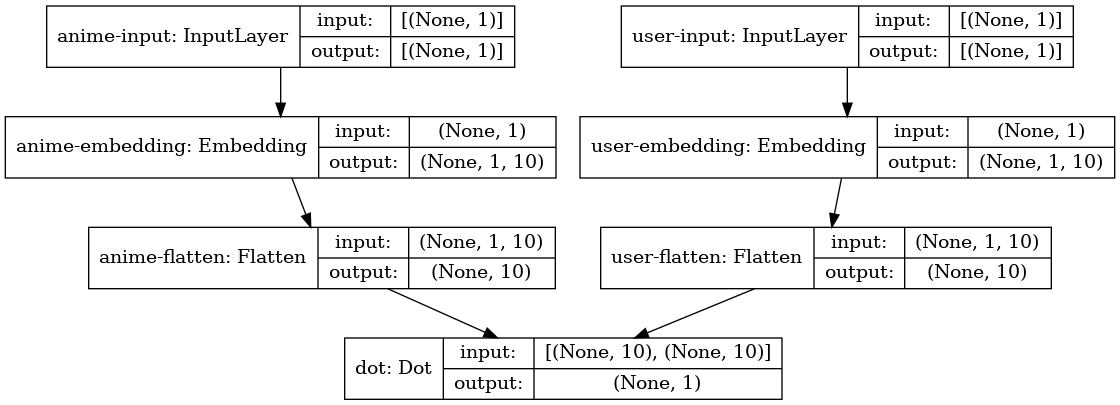

In [20]:
plot_model(model_MF, show_shapes=True)

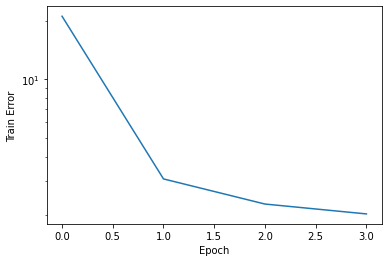

NameError: name 'model' is not defined

In [21]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

y_hat = np.round(model.predict([test.user_id, test.anime_id]), decimals=2)
y_true = test.rating
mean_absolute_error(y_true, y_hat)

# Neural network with MF 

## MF + Multilayer model

In [21]:
# Matrix factorization
latent_dim = 10

anime_input = Input(shape=[1],name='anime-input')
anime_embedding = Embedding(num_animes + 1, latent_dim, name='anime-embedding')(anime_input)
anime_vec = Flatten(name='anime-flatten')(anime_embedding)

user_input = Input(shape=[1],name='user-input')
user_embedding = Embedding(num_users + 1, latent_dim, name='user-embedding')(user_input)
user_vec = Flatten(name='user-flatten')(user_embedding)
from keras.layers import dot
prod = dot([anime_vec, user_vec], axes=1, normalize=False)

2021-08-30 16:06:54.280968: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-30 16:06:54.281162: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-30 16:06:54.281196: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-TVGBETP): /proc/driver/nvidia/version does not exist
2021-08-30 16:06:54.281678: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
# Adding NN upon MF

prod_dropout = Dropout(0.2)(prod)
fc_1 = Dense(100, name='fc-1', activation='relu')(prod)
fc_1_dropout = Dropout(0.2, name='fc-1-dropout')(fc_1)
fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_dropout = Dropout(0.2, name='fc-2-dropout')(fc_2)
fc_3 = Dense(1, name='fc-3', activation='relu')(fc_2_dropout)


model = Model([user_input, anime_input], fc_3)
model.compile(optimizer=Adam(lr=0.1), loss = 'mean_squared_error')

/home/ka_wagon/.pyenv/versions/anime_map/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


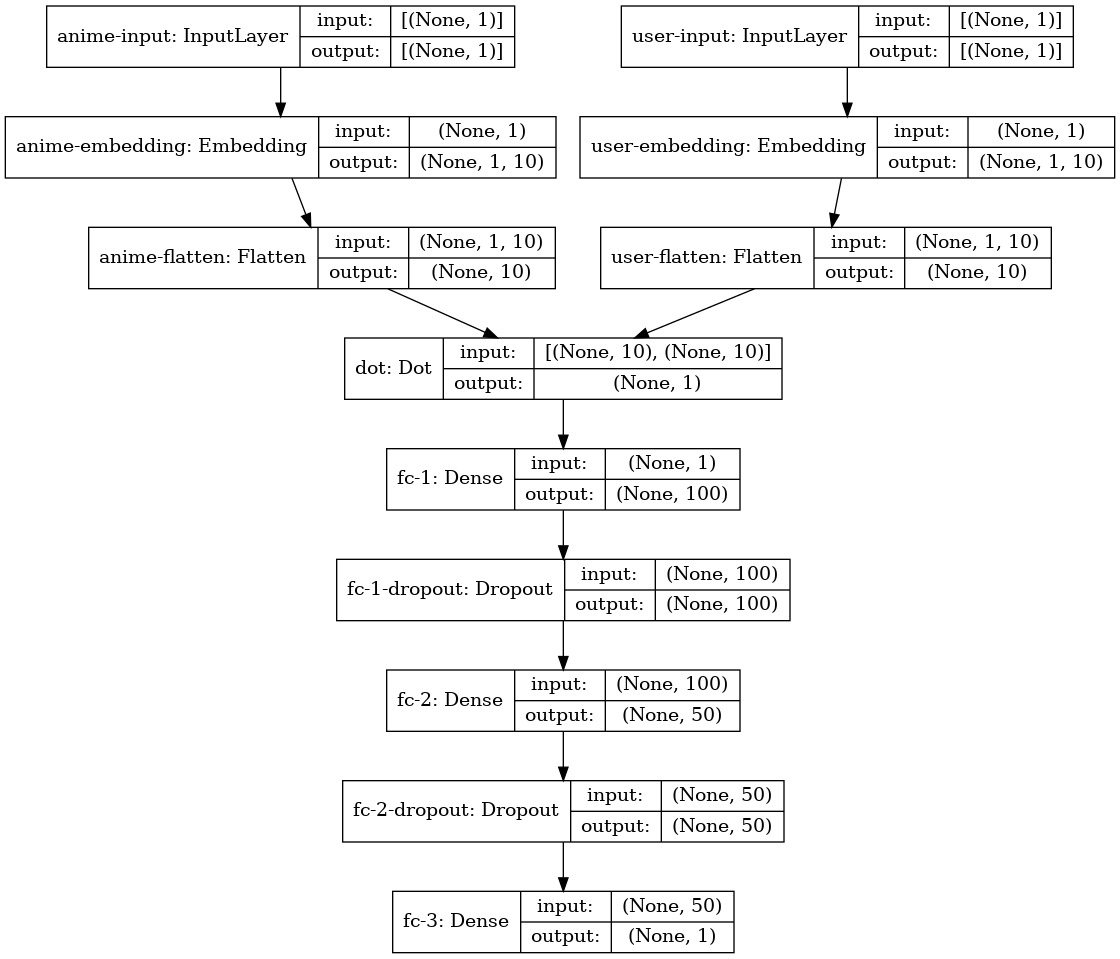

In [23]:
plot_model(model, show_shapes=True)

In [24]:
%%time
history = model.fit([train.user_id, train.anime_id], train.rating, epochs=5)

2021-08-30 16:06:55.161843: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
20561/20561 [==============================] - 169s 8ms/step - loss: 5.1735
Epoch 2/5
20561/20561 [==============================] - 158s 8ms/step - loss: 3.1267
Epoch 3/5
20561/20561 [==============================] - 158s 8ms/step - loss: 3.2173
Epoch 4/5
20561/20561 [==============================] - 214s 10ms/step - loss: 3.1203
Epoch 5/5
20561/20561 [==============================] - 190s 9ms/step - loss: 3.1200
CPU times: user 19min 7s, sys: 3min 44s, total: 22min 52s
Wall time: 14min 48s


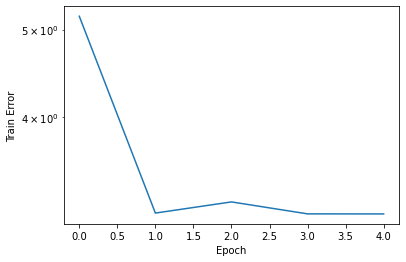

1.3812752595361442

In [25]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

y_hat = np.round(model.predict([test.user_id, test.anime_id]), decimals=2)
y_true = test.rating
mean_absolute_error(y_true, y_hat)

In [26]:
dataset.user_id[dataset.user_id==386974]

Series([], Name: user_id, dtype: int64)

In [28]:
recommendation_knn = [['Naruto: Shippuuden', 0.18049078542744768],
 ['Death Note', 0.32724375187989996],
 ['Bleach', 0.35922338431707146],
 ['Shingeki no Kyojin', 0.3764965221555553],
 ['Fullmetal Alchemist: Brotherhood', 0.4092187913883153],
 ['Code Geass: Hangyaku no Lelouch', 0.4141593159792041],
 ['Sword Art Online', 0.4145034622526954],
 ['One Piece', 0.4324693299705893],
 ['Fairy Tail', 0.43374727465720364],
 ['One Punch Man', 0.440672137299862]]

In [ ]:
from keras.models import load_model
model1 = load_model('/home/ka_wagon/code/mijka/anime_map/neuMFmodel.joblib')


# Multi-layer Perceptron

In [22]:
from keras.layers import  BatchNormalization

latent_dim = 10

# Define inputs
anime_input = Input(shape=[1],name='anime-input')
user_input = Input(shape=[1], name='user-input')

# MLP Embeddings
anime_embedding_mlp = Embedding(num_animes + 1, latent_dim, name='anime-embedding-mlp')(anime_input)
anime_vec_mlp = Flatten(name='flatten-anime-mlp')(anime_embedding_mlp)

user_embedding_mlp = Embedding(num_users + 1, latent_dim, name='user-embedding-mlp')(user_input)
user_vec_mlp = Flatten(name='flatten-user-mlp')(user_embedding_mlp)

# MF Embeddings
anime_embedding_mf = Embedding(num_animes + 1, latent_dim, name='anime-embedding-mf')(anime_input)
anime_vec_mf = Flatten(name='flatten-anime-mf')(anime_embedding_mf)

user_embedding_mf = Embedding(num_users + 1, latent_dim, name='user-embedding-mf')(user_input)
user_vec_mf = Flatten(name='flatten-user-mf')(user_embedding_mf)

# MLP layers
concat = concatenate([anime_vec_mlp, user_vec_mlp], axis=1, name='concat')
concat_dropout = Dropout(0.2)(concat)
fc_1 = Dense(100, name='fc-1', activation='relu')(concat_dropout)
fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
fc_1_dropout = Dropout(0.2)(fc_1_bn)
fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)
fc_2_dropout = Dropout(0.2)(fc_2_bn)

# Prediction from both layers
pred_mlp = Dense(10, name='pred-mlp', activation='relu')(fc_2_dropout)
pred_mf = dot([anime_vec_mf, user_vec_mf], axes=1, normalize=False, name='pred-mf')
combine_mlp_mf = concatenate([pred_mf, pred_mlp], axis=1, name='combine-mlp-mf')

# Final prediction
result = Dense(1, name='result', activation='relu')(combine_mlp_mf)

model = Model([user_input, anime_input], result)
model.compile(Adam(learning_rate=0.01), loss='mean_absolute_error')

history = model.fit([train.user_id, train.anime_id], train.rating, epochs=10)
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

y_hat = np.round(model.predict([test.user_id, test.anime_id]), decimals=2)
y_true = test.rating
mean_absolute_error(y_true, y_hat)